## Machine Learning and Artificial Intelligence, MSc Business Mathematics
## Online Retail Analysis Project
### Angelos Semoglou, s3332318
#### **`Part 2: RFM Analysis, Customer Segmentation using RFM Quantile Scores and Category Spending Patterns`**


***

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import squarify as sqf

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

***

### Load Previously Processed Data from Part 1

In [2]:
all_data = pd.read_csv('processed_online_retail.csv')

# 'customer_id' column to string type 
all_data['customer_id'] = all_data['customer_id'].astype(str)   

# 'invoice_date' column to datetime type
all_data['invoice_date'] = pd.to_datetime(all_data['invoice_date'])

In [3]:
display(all_data.head(3))

,invoice_id,product_id,description,quantity,invoice_date,price_per_unit,customer_id,country,invoice_amount,year,month,day,hour,season,category
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010,12,1,8,Winter,Vintage Design
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,1,8,Winter,Urban Home & Jewellery
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010,12,1,8,Winter,Urban Home & Jewellery


***

### Customer Segmentation

### 1. RFM Analysis 

- **Recency (R)** \
Recency measures how recently a customer made a purchase. This metric helps to identify customers who have engaged recently, under the assumption that the more recent the purchase, the more likely the customer will remain engaged.

    $R = \text{{Current Date}} - \text{{Last Purchase Date}}$

- **Frequency (F)** \
Frequency measures how often a customer makes a purchase within a defined period of time. A higher frequency indicates a higher engagement level and loyalty.

    $F = \text{{Total Number of Purchases during a given period}}$

- **Monetary Value (M)** \
Monetary value measures how much money a customer has spent with the brand over a period of time. It helps in identifying the highest spending customers who are contributing more to the revenue.

    $M = \text{{Total Money Spent during a given period}}$

**Calculate Total Spend and Record Transaction Dates for each Invoice**

In [4]:
invoice_level_data = all_data.groupby('invoice_id').agg({
    'customer_id': 'first',  
    'invoice_date': 'max',  # The most recent date of the invoice
    'invoice_amount': 'sum' 
}).rename(columns={'invoice_amount': 'basket_price'}).reset_index()

**Calculate RFM (Recency, Frequency, Monetary Value) Metrics for every `'customer_id'`**

In [5]:
# Current date for recency calculation (using the last date in the dataset +1 day)
current_date = all_data['invoice_date'].max() + pd.Timedelta(days=1)

# Group by customer_id to calculate RFM metrics
rfm = invoice_level_data.groupby('customer_id').agg({
    'invoice_date': lambda x: (current_date - x.max()).days,  # Recency: days since last invoice
    'invoice_id': 'count',  # Frequency: count of unique invoices
    'basket_price': 'sum'  # Monetary: sum of total price from all invoices
}).rename(columns={'invoice_date': 'Recency',
                   'invoice_id': 'Frequency',
                   'basket_price': 'Monetary'})

rfm_df = rfm.copy()

In [6]:
display(rfm_df.head(5))

,Recency,Frequency,Monetary
customer_id,,,
12346.0,326,2,0.00
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


In [7]:
rfm_df.describe()

,Recency,Frequency,Monetary
count,4339.000000,4339.000000,4339.000000
mean,90.839364,5.011293,1936.149860
std,99.479722,9.215449,8363.373452
min,1.000000,1.000000,0.000000
25%,17.000000,1.000000,300.975000
50%,50.000000,3.000000,654.670000
75%,139.500000,5.000000,1624.035000
max,374.000000,246.000000,279594.620000


- ### Visualizing RFM Distributions and Identifying Outliers

In [8]:
def distributions(df, wantlim):
    plt.figure(figsize = (18, 5))
    
    lim = df.count()[0]
    lim = lim*1.2
    
    # Plotting histogram for Recency
    plt.subplot(1, 3, 1)
    sns.histplot(df['Recency'], bins = 30, kde = True)
    plt.title('Recency Distribution')

    # Plotting histogram for Frequency
    plt.subplot(1, 3, 2)
    sns.histplot(df['Frequency'], bins = 30, kde = True)
    plt.title('Frequency Distribution')
    if wantlim:
        plt.ylim(top=lim)

    # Plotting histogram for Monetary
    plt.subplot(1, 3, 3)
    sns.histplot(df['Monetary'], bins = 30, kde = True)
    plt.title('Monetary Distribution')
    if wantlim:
        plt.ylim(top=lim)
        
    plt.tight_layout()
    plt.show()
    
def boxplots(df):
    # Visualizing potential outliers in the RFM data
    plt.figure(figsize = (15, 5))

    # Plotting boxplots for RFM data
    plt.subplot(1, 3, 1)
    sns.boxplot(df['Recency'])
    plt.title('Recency Distribution')

    plt.subplot(1, 3, 2)
    sns.boxplot(df['Frequency'])
    plt.title('Frequency Distribution')

    plt.subplot(1, 3, 3)
    sns.boxplot(df['Monetary'])
    plt.title('Monetary Distribution')

    plt.show()

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) 

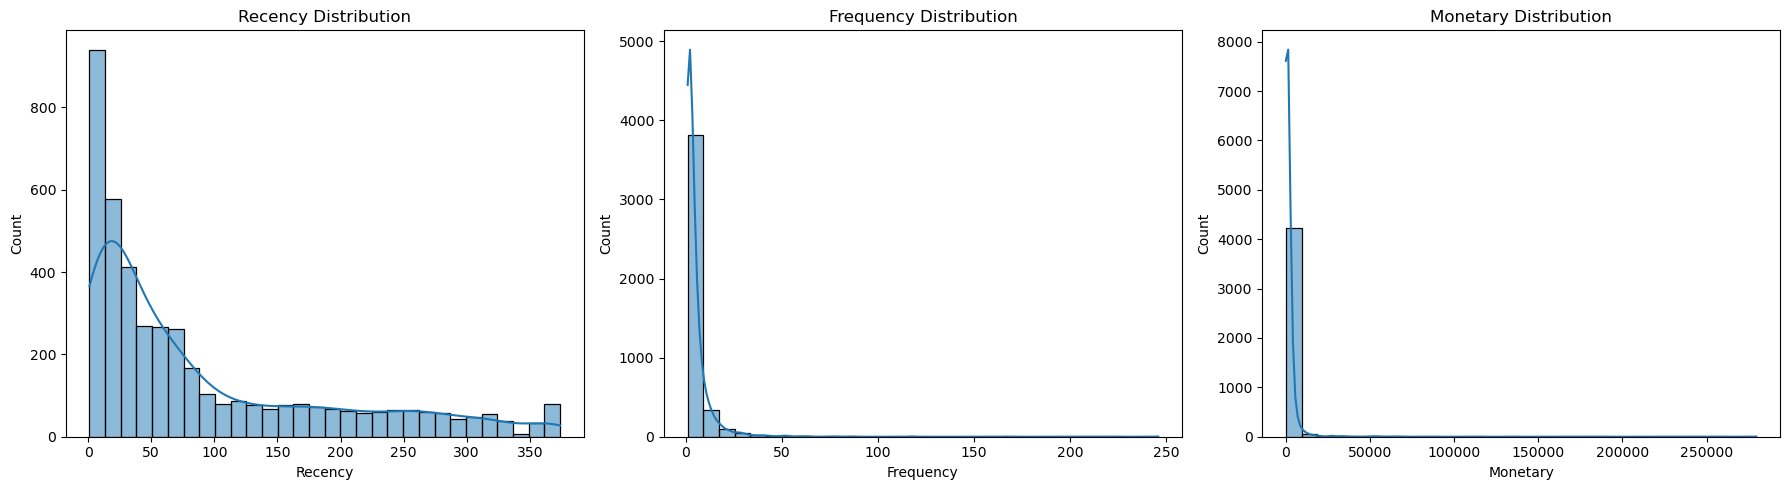

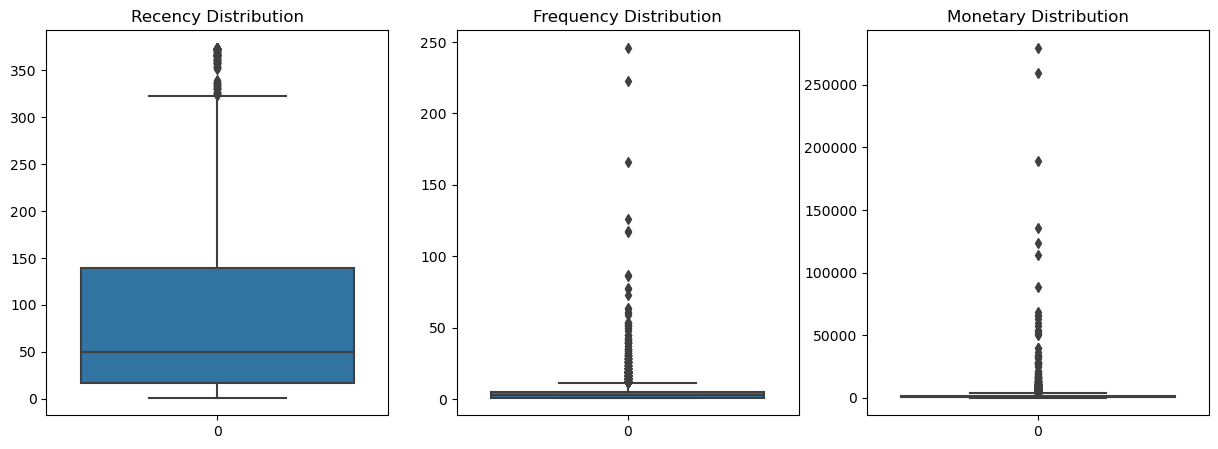

In [9]:
distributions(rfm_df, False)
boxplots(rfm_df)

**Recency**: The distribution appears to be fairly uniform without extreme outliers
  
**Frequency & Monetary Value**: There are a number of outliers that are very high compared to the majority of the data

- ### Handling Outliers with Upper Clipping

In [10]:
rfm_df_clipped = rfm_df.copy()
q = [0.8, 0.9, 0.95, 0.99]
display(rfm_df.quantile(q))

,Recency,Frequency,Monetary
0.80,176.4,7.0,2012.0040
0.90,261.0,11.0,3539.6440
0.95,311.0,16.0,5671.1460
0.99,368.0,35.0,18199.2204


In [11]:
# Clipping thresholds

# 99% (percentile) threshold for Frequency
frequency_clip = rfm_df['Frequency'].quantile(0.99) 

# 95% (percentile) threshold for Monetary
monetary_clip = rfm_df['Monetary'].quantile(0.95) 

# Applying clipping
rfm_df_clipped['Recency'] = rfm_df_clipped['Recency'].clip(upper=365) # Year threshold for Recency
rfm_df_clipped['Frequency'] = rfm_df_clipped['Frequency'].clip(upper=frequency_clip)
rfm_df_clipped['Monetary'] = rfm_df_clipped['Monetary'].clip(upper=monetary_clip)

rfm_df_clipped.describe()

,Recency,Frequency,Monetary
count,4339.000000,4339.000000,4339.000000
mean,90.760313,4.687025,1275.057936
std,99.258724,5.828915,1484.568838
min,1.000000,1.000000,0.000000
25%,17.000000,1.000000,300.975000
50%,50.000000,3.000000,654.670000
75%,139.500000,5.000000,1624.035000
max,365.000000,35.000000,5671.146000


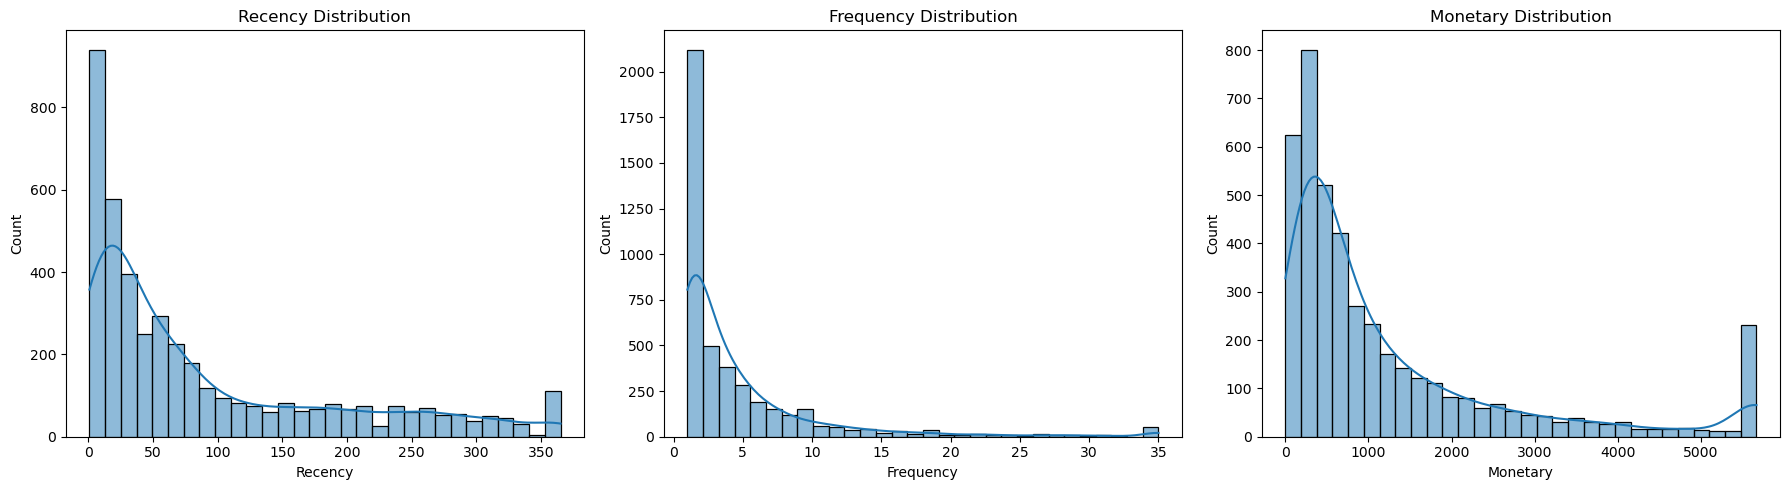

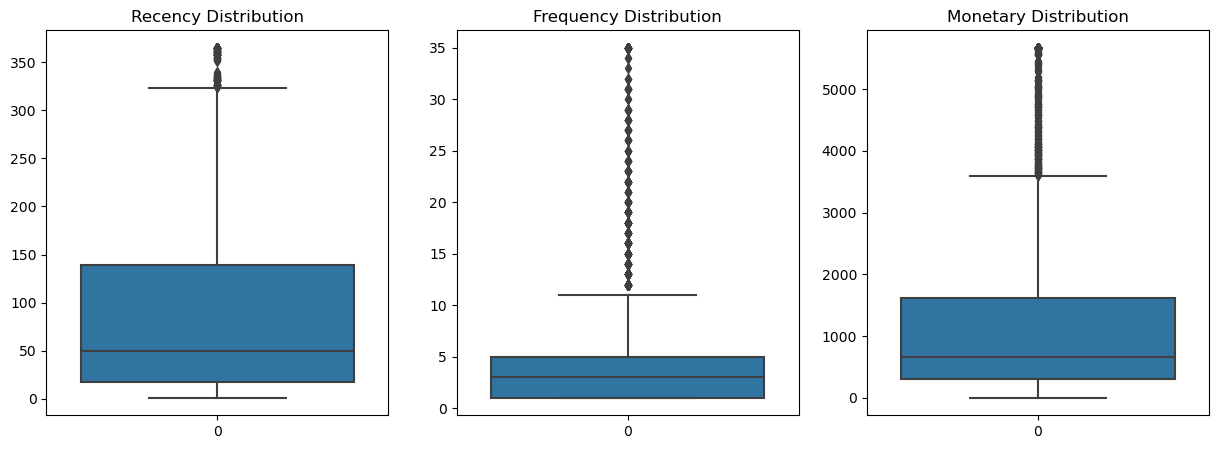

In [12]:
distributions(rfm_df_clipped, False)
boxplots(rfm_df_clipped)

**Reduction of Upper Outliers**: The application of clipping to the upper percentiles has effectively moderated the extremity of the highest values. This intervention has helped standardize the data, reducing the impact of outliers that could skew further analyses. Importantly, this adjustment has been achieved without significantly altering the overall distribution.

In [13]:
# Scaling the RFM metrics
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_df_clipped[['Recency',
                                                  'Frequency',
                                                  'Monetary']])

##### **Determining the Optimal Number of Clusters using Elbow Method and Silhouette Scores**

In [14]:
def plot_elbow_and_silhouette(data, 
                              k_range=range(2, 21),
                              n_init=10,
                              random_state=42):
    
    inertia = []
    silhouette_scores = []

    for k in k_range:
        kmeans = KMeans(n_clusters=k,
                        n_init=n_init,
                        random_state=random_state)
        kmeans.fit(data)
        inertia.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(data, kmeans.labels_))

    fig, ax1 = plt.subplots(figsize=(10, 6))
    color_elbow = '#0048B1'
    ax1.set_xlabel('Number of Clusters')
    ax1.set_ylabel('Inertia', color=color_elbow)
    line1 = ax1.plot(k_range,
                     inertia,
                     marker='o',
                     color=color_elbow,
                     label='Elbow Method')
    
    ax1.tick_params(axis='y',
                    labelcolor=color_elbow)
    ax1.set_xticks(k_range)
    ax1.grid(True)

    ax2 = ax1.twinx()
    color_silhouette = '#D3212D'
    ax2.set_ylabel('Silhouette Score', color=color_silhouette)
    line2 = ax2.plot(k_range,
                     silhouette_scores,
                     marker='o',
                     color=color_silhouette,
                     label='Silhouette Score')
    
    ax2.tick_params(axis='y',
                    labelcolor=color_silhouette)
    ax2.set_xticks(k_range)

    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper right')

    plt.title('Elbow Method and Silhouette Scores')
    plt.show()

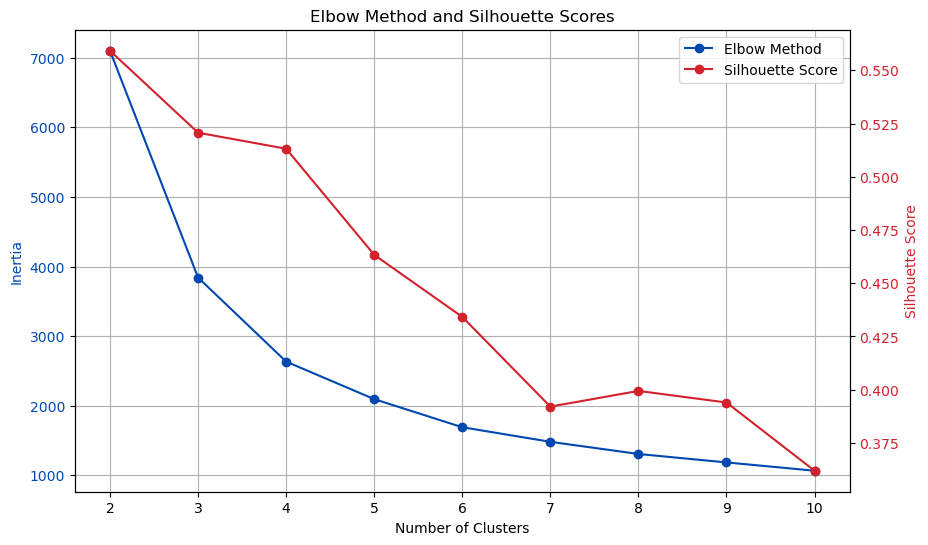

In [15]:
plot_elbow_and_silhouette(rfm_scaled, range(2, 11))

**Balance between Sum of Standard Errors Reduction and Simplicity**:
   - While 3 clusters provide better Silhouette Score, this may be too simplistic for meaningful customer segmentation, it may not capture the finer distinctions between different customer behaviors as effectively as $k = 4$.
   - Choosing 4 clusters offers a balance where the SSE is significantly reduced, and the clusters are still well-defined without being overly complex.

In [16]:
# Optimal number of clusters based on the previous analysis
optimal_k = 4

# Fitting KMeans with the optimal number of clusters
kmeans_optimal = KMeans(n_clusters=optimal_k,
                        n_init=10,
                        random_state=42)

rfm_df_with_clusters = rfm_df_clipped.copy()
rfm_df_with_clusters['cluster'] = kmeans_optimal.fit_predict(rfm_scaled)

In [17]:
# Generating a summary with mean and count values for each cluster
cluster_summary = rfm_df_with_clusters.groupby('cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(1)

# Renaming the columns for better readability
cluster_summary.columns = ['Average Recency',
                           'Average Frequency',
                           'Average Monetary',
                           'Customer Count']
display(cluster_summary)

,Average Recency,Average Frequency,Average Monetary,Customer Count
cluster,,,,
0,249.5,1.7,408.8,1019
1,30.4,9.1,3224.9,714
2,48.1,2.9,720.2,2404
3,10.6,25.5,5356.5,202


#### Assigning Names to Clusters
 
- `Cluster 0` : **At-Risk** (Not engaged with the business recently, purchase infrequently, and spend relatively little)
- `Cluster 1` : **Loyal Customers** (Engaged customers who purchase frequently and have high spending)
- `Cluster 2` : **Potential Loyalists** (Customers with moderate recency and spending - show potential for becoming loyal customers)
- `Cluster 3` : **VIP's** ( Top customers who purchase very frequently and spend the most)

In [18]:
# Mapping cluster numbers to descriptive names
cluster_names = {
    0: 'At-Risk',
    1: 'Loyal Customers',
    2: 'Potential Loyalists',
    3: 'VIPs'
}

In [19]:
# Adding cluster names to the summary
cluster_summary['Customer Category'] = cluster_summary.index.map(cluster_names)
cluster_summary = cluster_summary.reset_index(drop=True)
cluster_summary = cluster_summary[['Customer Category',
                                   'Average Recency',
                                   'Average Frequency',
                                   'Average Monetary',
                                   'Customer Count']]

display(cluster_summary)

,Customer Category,Average Recency,Average Frequency,Average Monetary,Customer Count
0,At-Risk,249.5,1.7,408.8,1019
1,Loyal Customers,30.4,9.1,3224.9,714
2,Potential Loyalists,48.1,2.9,720.2,2404
3,VIPs,10.6,25.5,5356.5,202


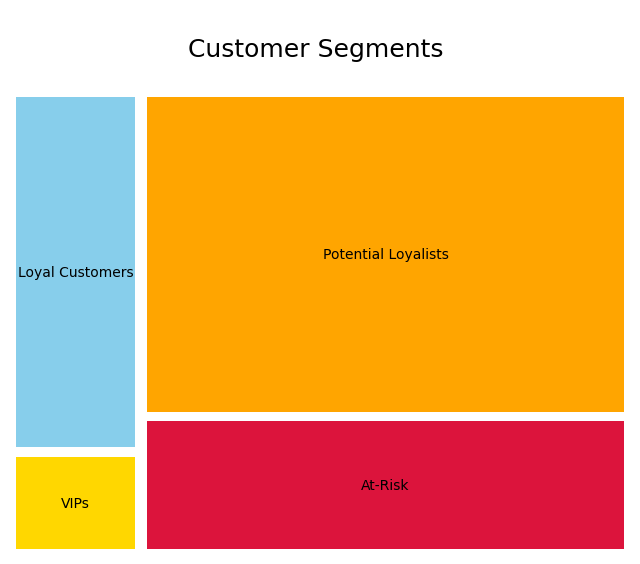

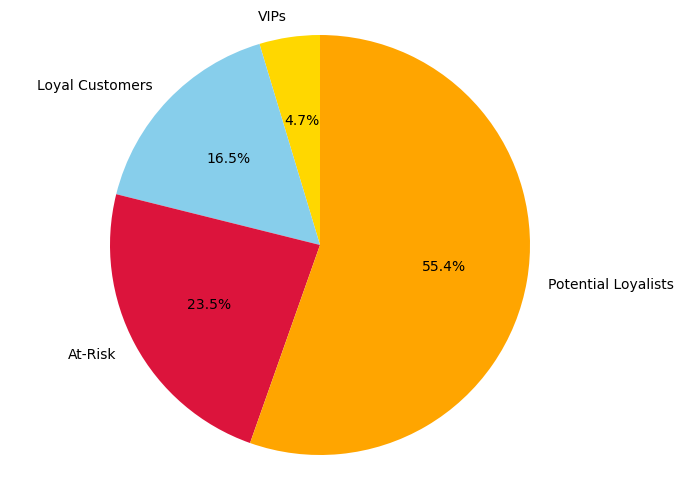

In [20]:
def segment_visualizations(df, x, y,
                            size_col,
                            label_col,
                            colors,
                            title,
                            sort_by='size',
                            ascending=False,
                            plot_types=['treemap', 'pie']):
    
    # Copy and sort the DataFrame
    sorted_df = df.copy()
    sorted_df = sorted_df.sort_values(by=sort_by, ascending=ascending)

    # Extract sizes and labels
    sizes = sorted_df[size_col].tolist()
    labels = sorted_df[label_col].tolist()

    for plot_type in plot_types:
        if plot_type == 'treemap':
            plt.figure(figsize=(x, y))
            ax = plt.gca()
            sqf.plot(sizes=sizes, label=labels, color=colors, alpha=1.0, ax=ax, pad=True)
            plt.title(f"\n{title} \n", fontsize=18, fontweight='normal')
            plt.axis('off')
            plt.show()
            print('\n'*2)

        elif plot_type == 'pie':
            plt.figure(figsize=(x, y))
            plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
            plt.axis('equal') 
            plt.show()
            print('\n'*2)


colors = ['gold', 'skyblue', 'crimson', 'orange']

segment_visualizations(
    cluster_summary,
    8,
    6,
    'Customer Count',
    'Customer Category',
    colors,
    'Customer Segments',
    sort_by='Customer Count',
    ascending=True
)

***

### 2. Customer Segmentation
### RFM Quantile Scores & Category Spending Patterns

- #### Revenue Percentage per Category per Customer
  The revenue percentage for each category per customer is calculated by dividing the total revenue a customer generates in a specific category by their total spending across all categories. This metric is then expressed as a percentage, indicating the proportion of total spending that each category represents.
  
  $\text{Revenue Percentage} = \left( \frac{\text{Revenue from Category per Customer}}{\text{Total Revenue from Customer}} \right) \times 100$


In [21]:
category_revenue = all_data.groupby(['customer_id', 'category']).agg({'invoice_amount': 'sum'}).unstack(fill_value=0)
category_revenue.columns = category_revenue.columns.droplevel(0)
category_revenue.columns = ['pct_' + col.lower().replace(' ', '_') for col in category_revenue.columns] 

category_revenue = category_revenue.clip(lower=0)

# Calculate the total spending per customer across all categories again
total_spending_per_customer = category_revenue.sum(axis=1)

# Convert each entry to a percentage of the total spending
category_percentage = category_revenue.div(total_spending_per_customer, axis=0) * 100

# Fill NaN values with 0 (NaN can occur if total spending is zero and results in a division by zero)
category_percentage.fillna(0, inplace=True)

In [22]:
display(category_percentage.head(3))

,pct_accessories,pct_classic_artistry,pct_holiday_essentials,pct_urban_home_&_jewellery,pct_vintage_design
customer_id,,,,,
12346.0,0.000000,0.000000,0.000000,0.000000,0.000000
12347.0,12.041531,26.375870,11.237123,29.540371,20.805104
12348.0,20.030714,41.953217,38.016069,0.000000,0.000000


- #### "Dominant" Category per Customer
  The "Dominant" Category per Customer refers to the product category from which a customer has purchased the most, either in terms of revenue generated or the number of transactions.
    $$
    \text{Dominant Category}_i = \underset{c \in C}{\text{argmax}} \, P_{ic}
    $$
    where:
    - $i$ indexes the customers.
    - $c$ indexes the categories within the set of all categories $C$.
    - $P_{ic}$ represents the percentage of total spending that customer $i$ allocates to category $c$. 

    <br>**Binary Indicators for Dominant Categories** \
    After determining the dominant category, a binary indicator for each category is generated, defined as:
    $$
    I_{ic} = \begin{cases} 
    1 & \text{if } \text{Dominant Category}_i = c \\
    0 & \text{otherwise}
    \end{cases}
    $$
  $I_{ic}$ is the indicator variable showing whether category $c$ is the dominant category for customer $i$.


In [23]:
# Identify the dominant category for each customer
dominant_category = category_percentage.idxmax(axis=1)

# Create a binary column for each category indicating if it's the dominant category
for category in category_percentage.columns:
    category_percentage[f'dominant_{category}'] = (dominant_category == category).astype(int)

In [24]:
display(category_percentage.head(3))

,pct_accessories,pct_classic_artistry,pct_holiday_essentials,pct_urban_home_&_jewellery,pct_vintage_design,dominant_pct_accessories,dominant_pct_classic_artistry,dominant_pct_holiday_essentials,dominant_pct_urban_home_&_jewellery,dominant_pct_vintage_design
customer_id,,,,,,,,,,
12346.0,0.000000,0.000000,0.000000,0.000000,0.000000,1,0,0,0,0
12347.0,12.041531,26.375870,11.237123,29.540371,20.805104,0,0,0,1,0
12348.0,20.030714,41.953217,38.016069,0.000000,0.000000,0,1,0,0,0


- #### Recency, Frequency & Monetary Scores (0-99) using quantiles
  Customers are scored on a scale from 0 to 99 for each RFM metric based on quantiles. This scoring system aligns RFM analysis with other percentage-based metrics, facilitating integrated insights across different analyses. \
  Quantiles are calculated by dividing the customer base into 100 equal parts based on the distribution of each RFM metric.
  This standardized scoring method allows for integrating RFM analysis with other metrics in a cohesive manner, enhancing the strategic insights gained.


    $R\  Score = 99 - \text{Quantile Rank of 'Recency'}$
    
    Here, the Recency score is inverted since a more recent purchase (lower recency) is better. Customers with the most recent purchases rank higher on the scale.
    
    $F\  Score = \text{Quantile Rank of 'Frequency'}$
    
    Customers who purchase more frequently receive a higher score, placing them in higher quantiles.
    
    $M\  Score = \text{Quantile Rank of 'Monetary'}$
    
    Like Frequency, customers who have spent more are scored higher, reflecting their greater economic value to the business.

In [25]:
# Convert RFM metrics to quantile scores
rfm_scores = rfm_df.copy() # Copy the RFM metrics DataFrame to avoid modifying the original


# Loop through each column in the RFM scores DataFrame
for column in rfm_scores.columns:
    # Rank the values in the column, with ties assigned the first rank in the group
    # pd.qcut then cuts these ranked values into 100 quantiles
    # The labels parameter assigns a score from 0 to 99 to each quantile
    rfm_scores[column] = pd.qcut(rfm_scores[column].rank(method='first'),
                                 100,
                                 labels=range(100)).astype(int)

# Invert the Recency score - Lower Recency = Higher Score
rfm_scores['Recency'] = 99 - rfm_scores['Recency']

In [26]:
rfm_scores.rename(columns={'Recency':'Recency Score',
                           'Frequency':'Frequency Score',
                           'Monetary':'Monetary Score'},
                  inplace = True)

In [27]:
display(rfm_scores.head(3))

,Recency Score,Frequency Score,Monetary Score
customer_id,,,
12346.0,3,30,0
12347.0,97,79,92
12348.0,37,60,77


### Customer Features DataFrame

In [28]:
category_percentage.index.name = 'customer_id'
rfm_scores.index.name = 'customer_id'

# Combine the modified category percentage DataFrame with RFM scores
combined_df = category_percentage.join(rfm_scores,
                                       how='inner') # Inner Join

In [29]:
display(combined_df.head(3))

,pct_accessories,pct_classic_artistry,pct_holiday_essentials,pct_urban_home_&_jewellery,pct_vintage_design,dominant_pct_accessories,dominant_pct_classic_artistry,dominant_pct_holiday_essentials,dominant_pct_urban_home_&_jewellery,dominant_pct_vintage_design,Recency Score,Frequency Score,Monetary Score
customer_id,,,,,,,,,,,,,
12346.0,0.000000,0.000000,0.000000,0.000000,0.000000,1,0,0,0,0,3,30,0
12347.0,12.041531,26.375870,11.237123,29.540371,20.805104,0,0,0,1,0,97,79,92
12348.0,20.030714,41.953217,38.016069,0.000000,0.000000,0,1,0,0,0,37,60,77


### Cluster Evaluation Methods

1. **Feature Importance Analysis with Random Forest**
    - Function that trains a Random Forest and plots the feature importances to understand the impact of each feature on the model.
2. **Clustering Performance Metrics**
    - Function that computes Silhouette Score, Davies-Bouldin Index, and Calinski-Harabasz Index to assess clustering quality. 
3. **t-SNE Visualization of Clustering**
    - Function that visualizes high-dimensional data in two dimensions using t-SNE, highlighting the distribution of clusters. 

In [30]:
def plot_feature_importances(df, labels, title):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(df, labels)
    
    importances = rf.feature_importances_
    feature_importances = pd.DataFrame({'Feature': df.columns, 'Importance': importances})
    feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

    cmap = plt.get_cmap('viridis')
    colors = cmap(feature_importances['Importance'].values / feature_importances['Importance'].max())
    
    plt.figure(figsize=(10, 6))
    plt.title(f'Feature Importances for {title}')
    plt.barh(feature_importances['Feature'],
             feature_importances['Importance'],
             color=colors,
             align='center')
    plt.gca().invert_yaxis()
    plt.xlabel('Relative Importance')
    plt.show()
    
    return feature_importances

def display_clustering_metrics(data, labels, title):
    silhouette_avg = silhouette_score(data, labels)
    davies_bouldin_avg = davies_bouldin_score(data, labels)
    calinski_harabasz_avg = calinski_harabasz_score(data, labels)
    
    print(f'Metrics for {title}:')
    print(f'Silhouette Score: {silhouette_avg}')
    print(f'Davies-Bouldin Index: {davies_bouldin_avg}')
    print(f'Calinski-Harabasz Index: {calinski_harabasz_avg}')
    print()
    
    return silhouette_avg, davies_bouldin_avg, calinski_harabasz_avg


def plot_tsne(data, labels, title):
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(data)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(tsne_results[:, 0],
                          tsne_results[:, 1],
                          c=labels,
                          cmap='viridis',
                          alpha=0.7)
    plt.colorbar(scatter, ticks=range(len(set(labels))))
    plt.title(title)
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.show()

### 1. KMeans Clustering

In [31]:
# Standardize the data
scaler = StandardScaler()
standardized_data = scaler.fit_transform(combined_df)

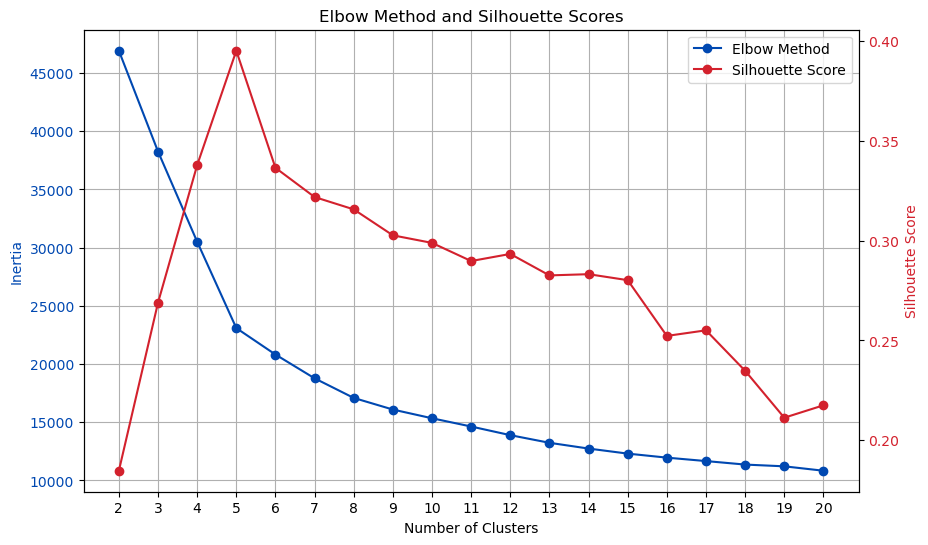

In [32]:
plot_elbow_and_silhouette(standardized_data, range(2, 21))

**We observe that** $k = 5$ **seems to be the optimal number of clusters.**

In [33]:
kmeans = KMeans(n_clusters = 5,
                n_init = 10,
                random_state = 42)
kmeans.fit(standardized_data)

# Assign cluster labels back to the DataFrame
combined_df_clusters = combined_df.copy()
cluster_labels_km = kmeans.labels_
combined_df_clusters['cluster'] = cluster_labels_km

In [34]:
# Calculate mean values for each cluster
cluster_means = combined_df_clusters.groupby('cluster').mean()

# Calculate the number of customers in each cluster
cluster_sizes = combined_df_clusters['cluster'].value_counts().reset_index()

cluster_sizes.columns = ['cluster', 'Number_of_customers']

# Merge the mean values and cluster sizes on the 'cluster' column
kmeans_summary = cluster_means.merge(cluster_sizes, on = 'cluster')

kmeans_summary.set_index('cluster', inplace=True)

In [35]:
display(kmeans_summary)

,pct_accessories,pct_classic_artistry,pct_holiday_essentials,pct_urban_home_&_jewellery,pct_vintage_design,dominant_pct_accessories,dominant_pct_classic_artistry,dominant_pct_holiday_essentials,dominant_pct_urban_home_&_jewellery,dominant_pct_vintage_design,Recency Score,Frequency Score,Monetary Score,Number_of_customers
cluster,,,,,,,,,,,,,,
0,13.300950,19.124135,9.901662,12.788042,44.885211,0.0,0.0,0.0,0.0,1.0,52.342511,53.354626,53.575991,908
1,14.928056,16.665253,9.150931,43.538349,15.717412,0.0,0.0,0.0,1.0,0.0,51.781588,47.070397,46.824910,554
2,47.665341,15.509542,7.609716,14.442308,14.241178,1.0,0.0,0.0,0.0,0.0,45.459220,48.440603,48.499113,1128
3,12.600280,43.217620,14.131406,13.104110,16.946585,0.0,1.0,0.0,0.0,0.0,51.176124,50.792926,51.875461,1357
4,9.894911,19.765500,47.855930,9.383577,13.100082,0.0,0.0,1.0,0.0,0.0,45.517857,42.576531,38.494898,392


**Feature's Importance and Evaluation**

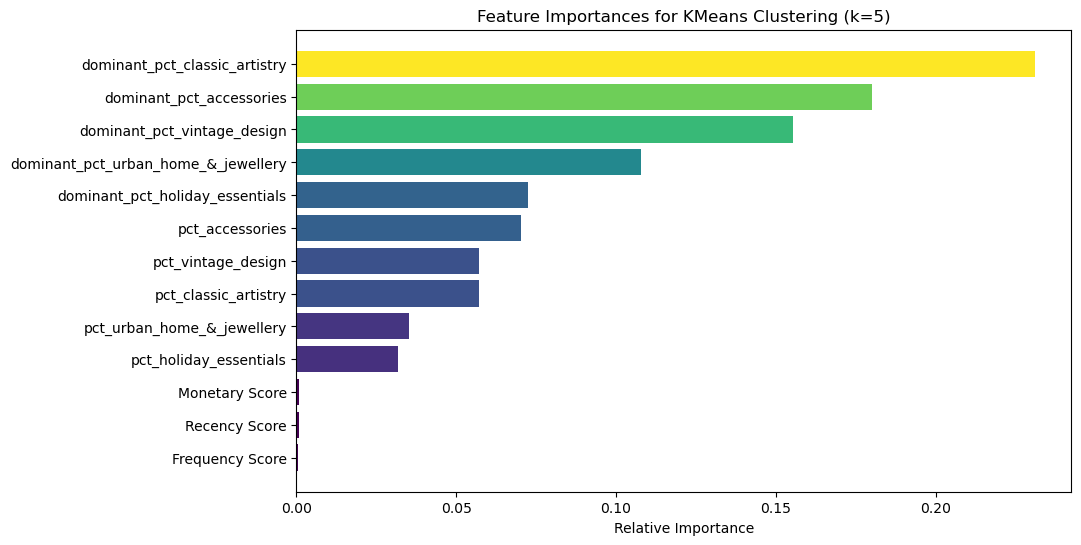

Metrics for KMeans Clustering (k=5):
Silhouette Score: 0.3950413561942424
Davies-Bouldin Index: 1.0327633185234322
Calinski-Harabasz Index: 1563.4976517153982



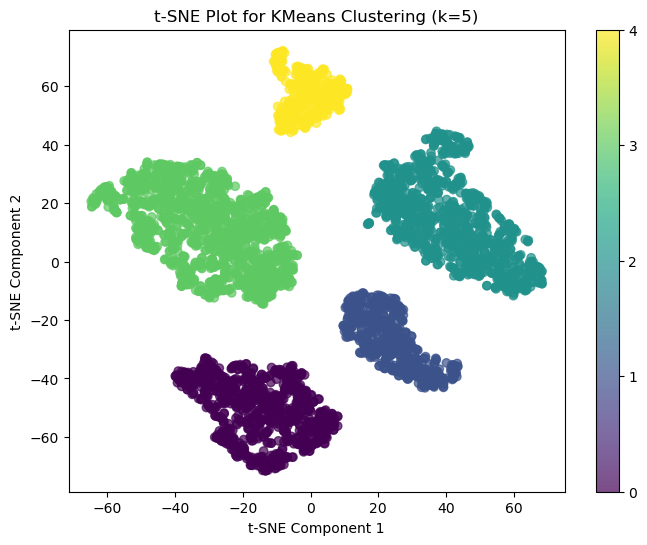

In [36]:
labels_kmeans = combined_df_clusters['cluster']

plot_feature_importances(combined_df,
                         labels_kmeans,
                         'KMeans Clustering (k=5)')

display_clustering_metrics(standardized_data,
                           labels_kmeans,
                           'KMeans Clustering (k=5)')

plot_tsne(standardized_data,
          cluster_labels_km,
          't-SNE Plot for KMeans Clustering (k=5)')

#### **KMeans Clustering Results $(k = 5)$ Overview**

The KMeans clustering results reveal five distinct clusters with varying spending patterns and dominant categories. Cluster sizes range from 392 to 1357 customers, indicating some imbalance, with Cluster 3 being the largest. Each cluster has a clear dominant category, such as Accessories in Cluster 2 and Urban Home & Jewellery in Cluster 3. The RFM scores vary across clusters, with Cluster 4 showing lower scores and Cluster 0 exhibiting relatively higher scores. This suggests that while KMeans provides clear segments, the large size of some clusters indicates the need for further clustering to better understand its diverse customer base.

**Business Insights**
- **Cluster 0**: Predominantly spends on `Vintage Design (44.88%)`. Customers in this cluster have relatively `high Recency, Frequency, and Monetary scores`, indicating they are valuable and active customers.
  
- **Cluster 1**: Dominated by `Urban Home & Jewellery (43.53%)`. This cluster has `moderate RFM scores`.

- **Cluster 2**: Primarily focused on `Accessories (47.66%)`. These customers have `moderate-low RFM scores`.
  
- **Cluster 3**: `Classic Artistry (43.21%)` is the dominant category. This is the largest cluster with `good RFM scores`.

- **Cluster 4**: Majorly spends on `Holiday Essentials (47.85%)`. This cluster has the `lowest RFM scores`.

**Need for Further Clustering**

While the five clusters provide a useful segmentation of the customer base, the size and diversity within some clusters suggest a need for further clustering to gain deeper insights. For instance:

- **Cluster 3**: With 1357 customers, this cluster is quite large and likely contains sub-segments with different behaviors and preferences within the Classic Artistry category. More granular clusters could help identify specific customer needs and tailor marketing strategies more effectively.
  
- **Cluster 4**: Despite its focus on Holiday Essentials, the lower RFM scores indicate varying levels of engagement within this group. Further clustering could help identify dormant customers versus those who are occasional buyers.

Given these insights, we will proceed with additional clustering to achieve a more nuanced segmentation. Implementing hierarchical clustering methods can provide a more detailed understanding of the customer base.

**Observation on Feature Importance**\
During the clustering process, it was observed that the feature importance of the Recency, Frequency, and Monetary (RFM) scores was near zero. This indicates that these features had minimal impact on determining the cluster assignments. This further supports the need for refining our clustering approach to ensure that all relevant aspects of customer behavior are adequately captured and utilized.

### 2. Hierarchical Clustering

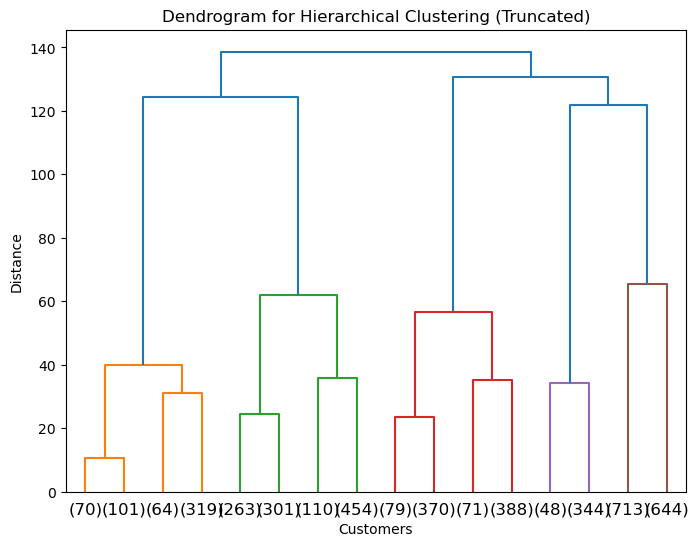

In [37]:
data = combined_df.copy()

# Standardize the data
scaler = StandardScaler()
standardized_data = scaler.fit_transform(data)

# Perform hierarchical clustering
Z = linkage(standardized_data,
            method='ward')

# Plot the dendrogram with truncation to reduce the number of splits shown
plt.figure(figsize=(8, 6))

dendrogram(Z,
           truncate_mode='level',
           p=3)  # 'p' controls the number of levels shown

plt.title("Dendrogram for Hierarchical Clustering (Truncated)")
plt.xlabel("Customers")
plt.ylabel("Distance")
plt.show()

cutoff_distance = 50  

# Assign cluster labels
cluster_labels_hc = fcluster(Z,
                             cutoff_distance,
                             criterion='distance')

# Add the cluster labels to the original DataFrame
combined_df_clusters_hc = combined_df.copy()
combined_df_clusters_hc['hierarchical_cluster'] = cluster_labels_hc

In [38]:
# Calculate mean values for each cluster
cluster_means = combined_df_clusters_hc.groupby('hierarchical_cluster').mean()

# Calculate the number of customers in each cluster
cluster_sizes = combined_df_clusters_hc['hierarchical_cluster'].value_counts().reset_index()

cluster_sizes.columns = ['hierarchical_cluster', 'Number_of_customers']

# Merge the mean values and cluster sizes on the 'cluster' column
hierarchical_summary = cluster_means.merge(cluster_sizes, on = 'hierarchical_cluster')

hierarchical_summary.set_index('hierarchical_cluster', inplace=True)

In [39]:
display(hierarchical_summary)

,pct_accessories,pct_classic_artistry,pct_holiday_essentials,pct_urban_home_&_jewellery,pct_vintage_design,dominant_pct_accessories,dominant_pct_classic_artistry,dominant_pct_holiday_essentials,dominant_pct_urban_home_&_jewellery,dominant_pct_vintage_design,Recency Score,Frequency Score,Monetary Score,Number_of_customers
hierarchical_cluster,,,,,,,,,,,,,,
1,14.928056,16.665253,9.150931,43.538349,15.717412,0.0,0.0,0.0,1.0,0.0,51.781588,47.070397,46.824910,554
2,39.203811,18.213949,8.806797,16.912325,16.863118,1.0,0.0,0.0,0.0,0.0,63.551418,70.285461,68.501773,564
3,56.126870,12.805134,6.412636,11.972292,11.619239,1.0,0.0,0.0,0.0,0.0,27.367021,26.595745,28.496454,564
4,14.408316,21.046239,9.925342,14.140385,40.479718,0.0,0.0,0.0,0.0,1.0,70.496659,76.605791,77.115813,449
5,12.217709,17.243906,9.878497,11.465163,49.194725,0.0,0.0,0.0,0.0,1.0,34.583878,30.610022,30.549020,459
6,9.894911,19.765500,47.855930,9.383577,13.100082,0.0,0.0,1.0,0.0,0.0,45.517857,42.576531,38.494898,392
7,13.823294,37.240423,14.651074,15.463103,18.822106,0.0,1.0,0.0,0.0,0.0,66.141655,71.709677,71.539972,713
8,11.246228,49.835232,13.556059,10.492366,14.870114,0.0,1.0,0.0,0.0,0.0,34.607143,27.635093,30.104037,644


**Feature's Importance and Evaluation**

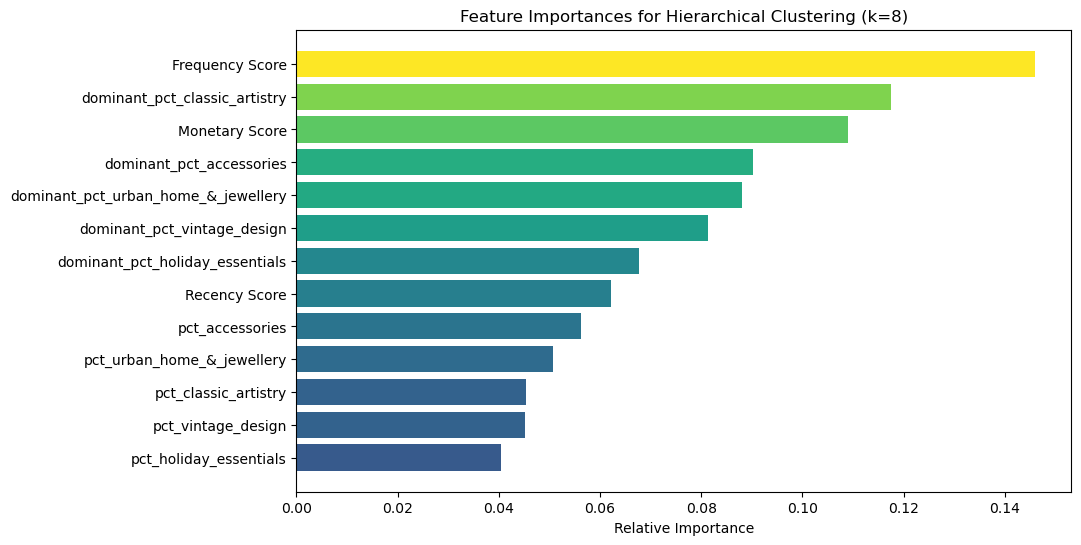

Metrics for Hierarchical Clustering (k=8):
Silhouette Score: 0.30279296396950095
Davies-Bouldin Index: 1.2497283645696478
Calinski-Harabasz Index: 1384.3285095473068



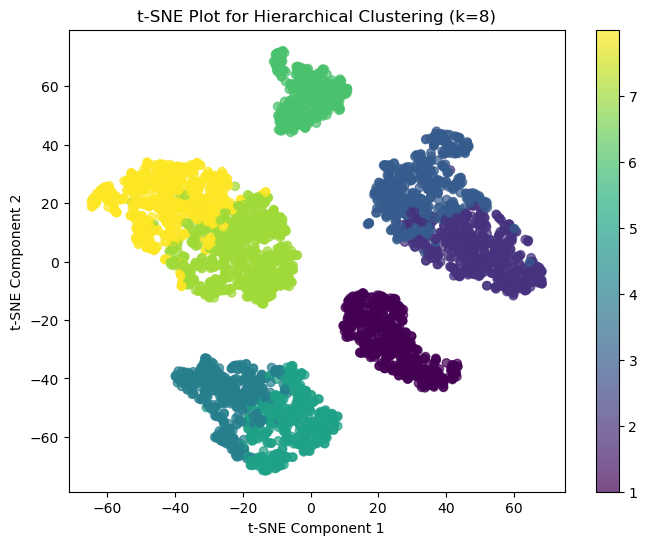

In [40]:
labels_hierarchical = combined_df_clusters_hc['hierarchical_cluster']

plot_feature_importances(combined_df,
                         labels_hierarchical,
                         'Hierarchical Clustering (k=8)')

display_clustering_metrics(standardized_data,
                           labels_hierarchical,
                           'Hierarchical Clustering (k=8)')

plot_tsne(standardized_data,
          cluster_labels_hc,
          't-SNE Plot for Hierarchical Clustering (k=8)')

#### **Hierarchical Clustering Results $(k = 8)$ Overview**

The hierarchical clustering results reveal eight distinct clusters with varying spending patterns and dominant categories. Cluster sizes range from 392 to 713 customers, providing a more granular segmentation compared to the initial KMeans clustering with $k = 5$. This finer segmentation helps in identifying more specific customer behaviors and preferences.

**Business Insights**
- **Cluster 1**: Predominantly spends on `Urban Home & Jewellery (43.53%)`. Customers in this cluster have `moderate RFM scores`.

- **Cluster 2**: Primarily focused on `Accessories (39.20%)`. These customers have `high RFM scores`, indicating they are active and valuable.

- **Cluster 3**: Primarily focused on `Accessories (56.12%)`. These customers have the `lowest RFM scores`, suggesting a need for re-engagement strategies.

- **Cluster 4**: Predominantly spends on `Vintage Design (40.47%)`. This cluster has the `highest RFM scores`, indicating very valuable customers. 

- **Cluster 5**: Predominantly spends on `Vintage Design (49.19%)`. This cluster has `low RFM scores`.

- **Cluster 6**: Majorly spends on `Holiday Essentials (47.85%)`. This cluster has `moderate RFM scores`, suggesting occasional buyers.

- **Cluster 7**: Predominantly spends on `Classic Artistry (37.24%)`. This cluster has `high RFM scores`, indicating active customers.

- **Cluster 8**: Predominantly spends on `Classic Artistry (49.83%)`. This cluster has `very low RFM scores`.


The hierarchical clustering with $k = 8$ has provided more detailed insights

**Next Steps**\
To further validate and potentially enhance these clustering results, we will also perform KMeans clustering with the same number of clusters $k = 8$ obtained from the dendrogram. We will compare the results of both methods using clustering metrics such as the silhouette score and Davies-Bouldin index, as well as business insights and features importancies. The final clustering method will be chosen based on a combination of these metrics and the actionable insights they provide for the business.


### 3. KMeans Clustering with Number of Clusters Determined by Hierarchical Clustering

In [41]:
num_clusters = len(set(labels_hierarchical))

kmeans = KMeans(n_clusters = num_clusters,
                n_init = 10,
                random_state = 42)
kmeans.fit(standardized_data)

# Assign cluster labels back to the DataFrame
combined_df_clusters = combined_df.copy()
cluster_labels_km = kmeans.labels_
combined_df_clusters['cluster'] = cluster_labels_km

In [42]:
# Calculate mean values for each cluster
cluster_means = combined_df_clusters.groupby('cluster').mean()

# Calculate the number of customers in each cluster
cluster_sizes = combined_df_clusters['cluster'].value_counts().reset_index()

cluster_sizes.columns = ['cluster', 'Number of Customers']

# Merge the mean values and cluster sizes on the 'cluster' column
kmeans_summary = cluster_means.merge(cluster_sizes, on = 'cluster')

kmeans_summary.set_index('cluster', inplace=True)

display(kmeans_summary)

,pct_accessories,pct_classic_artistry,pct_holiday_essentials,pct_urban_home_&_jewellery,pct_vintage_design,dominant_pct_accessories,dominant_pct_classic_artistry,dominant_pct_holiday_essentials,dominant_pct_urban_home_&_jewellery,dominant_pct_vintage_design,Recency Score,Frequency Score,Monetary Score,Number of Customers
cluster,,,,,,,,,,,,,,
0,11.899688,16.721321,9.282152,11.084059,51.012779,0.0,0.0,0.0,0.0,1.0,33.922737,30.359823,30.282561,453
1,40.130003,18.096768,8.837962,16.295445,16.639820,1.0,0.0,0.0,0.0,0.0,66.370787,72.629213,70.526217,534
2,13.866537,37.181121,15.010541,15.429796,18.512004,0.0,1.0,0.0,0.0,0.0,66.642659,71.894737,71.948753,722
3,9.894911,19.765500,47.855930,9.383577,13.100082,0.0,0.0,1.0,0.0,0.0,45.517857,42.576531,38.494898,392
4,14.928056,16.665253,9.150931,43.538349,15.717412,0.0,0.0,0.0,1.0,0.0,51.781588,47.070397,46.824910,554
5,14.696052,21.516387,10.518448,14.484536,38.784578,0.0,0.0,0.0,0.0,1.0,70.681319,76.248352,76.767033,455
6,54.439533,13.183651,6.505536,12.776357,12.084823,1.0,0.0,0.0,0.0,0.0,26.659933,26.695286,28.696970,594
7,11.160535,50.081167,13.131822,10.459785,15.166690,0.0,1.0,0.0,0.0,0.0,33.590551,26.800000,29.051969,635


**Feature's Importance and Evaluation**

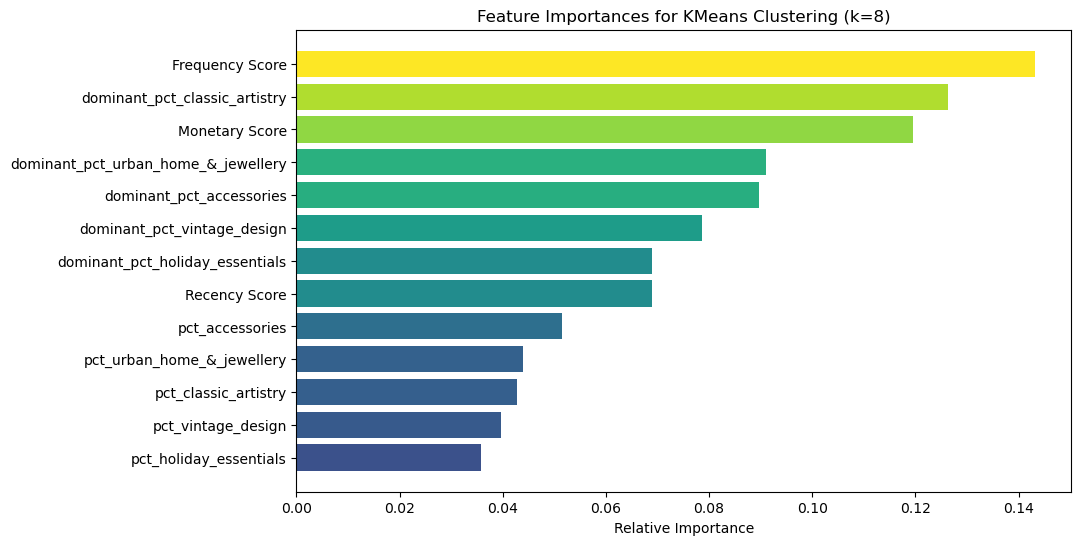

Metrics for KMeans Clustering (k=8):
Silhouette Score: 0.31561183062105025
Davies-Bouldin Index: 1.2034031102782925
Calinski-Harabasz Index: 1423.5975073719644



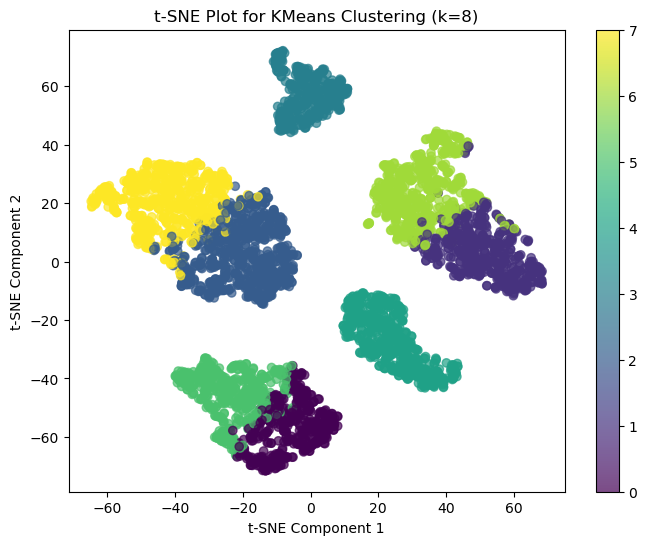

In [43]:
labels_kmeans = combined_df_clusters['cluster']

plot_feature_importances(combined_df,
                         cluster_labels_km,
                         'KMeans Clustering (k=8)')

display_clustering_metrics(standardized_data,
                           cluster_labels_km,
                           'KMeans Clustering (k=8)')

plot_tsne(standardized_data,
          cluster_labels_km,
          't-SNE Plot for KMeans Clustering (k=8)')

#### **KMeans Clustering Results $(k = 8)$ Overview**

The KMeans clustering results reveal eight distinct clusters with varying spending patterns and dominant categories. Cluster sizes range from 392 to 722 customers, providing a granular segmentation of the customer base.

**Business Insights**

- **Cluster 0**: Primarily focused on `Vintage Design (51.01%)`. These customers have `low RFM scores`, indicating they are less active.

- **Cluster 1**: Predominantly spends on `Accessories (40.13%)`. This cluster has `high RFM scores`, indicating strong customer engagement and value.

- **Cluster 2**: Primarily focused on `Classic Artistry (37.18%)`. This cluster also has `high RFM scores`.

- **Cluster 3**: Predominantly spends on `Holiday Essentials (47.85%)`. Customers in this cluster have `moderate RFM scores`, indicating a consistent yet average level of engagement and value.

- **Cluster 4**: Primarily focused on `Urban Home & Jewellery (43.53%)`. Customers in this cluster display `moderate RFM scores`, suggesting balanced engagement and value.

- **Cluster 5**: Majorly spends on `Vintage Design (38.78%)` and has the `highest RFM scores` among all clusters, indicating exceptional engagement and value.

- **Cluster 6**: Predominantly spends on `Accessories (54.43%)`. This cluster has the `lowest RFM scores`, indicating minimal engagement and low value.

- **Cluster 7**: Primarily focused on `Classic Artistry (50.08%)`. This cluster has `low RFM scores`, indicating limited engagement.

#### **Comparison of Clustering Methods** 
Both hierarchical and KMeans clustering with  $k = 8$ provide valuable insights into customer segmentation. The hierarchical clustering offers a more intuitive understanding of the cluster formation, while KMeans provides a more refined and optimized segmentation.

**1. Silhouette Score**: 
  - Hierarchical Clustering:  0.302
  - KMeans Clustering: 0.315

**2. Davies-Bouldin Index**: 
  - Hierarchical Clustering: 1.249
  - KMeans Clustering: 1.203

**3. Calinski-Harabasz Index**: 
  - Hierarchical Clustering: 1384.328
  - KMeans Clustering: 1423.597

#### **Final Decision and Business Strategy**
Based on the comparison of clustering metrics and the actionable business insights derived from each method, we will continue with the analysis of the KMeans clustering results.

In [44]:
# Mapping of cluster labels to descriptive names
cluster_names = {
    0: "Low-Engagement Vintage Design Shoppers",
    1: "High-Value Accessory Enthusiasts",
    2: "Valued Classic Artistry Connoisseurs",
    3: "Occasional Holiday Essentials Shoppers",
    4: "Active Urban Home & Jewellery Enthusiasts",
    5: "Premium Vintage Design Lovers",
    6: "Low-Engagement Accessory Seekers",
    7: "Understated Classic Artistry Enthusiasts"
}
# Apply the mapping to add a new column with the cluster names
combined_df_clusters['cluster'] = combined_df_clusters['cluster'].replace(cluster_names)
combined_df_clusters.rename(columns={'cluster':'Customer Segment'}, inplace=True)

# Calculate mean values for each cluster
cluster_means = combined_df_clusters.groupby('Customer Segment').mean().reset_index()

# Calculate the number of customers in each cluster
cluster_sizes = combined_df_clusters['Customer Segment'].value_counts().reset_index()
cluster_sizes.columns = ['Customer Segment', 'Number of Customers']

# Merge the mean values and cluster sizes
summary = cluster_means.merge(cluster_sizes, on='Customer Segment')

In [45]:
display(summary)

,Customer Segment,pct_accessories,pct_classic_artistry,pct_holiday_essentials,pct_urban_home_&_jewellery,pct_vintage_design,dominant_pct_accessories,dominant_pct_classic_artistry,dominant_pct_holiday_essentials,dominant_pct_urban_home_&_jewellery,dominant_pct_vintage_design,Recency Score,Frequency Score,Monetary Score,Number of Customers
0,Active Urban Home & Jewellery Enthusiasts,14.928056,16.665253,9.150931,43.538349,15.717412,0.0,0.0,0.0,1.0,0.0,51.781588,47.070397,46.824910,554
1,High-Value Accessory Enthusiasts,40.130003,18.096768,8.837962,16.295445,16.639820,1.0,0.0,0.0,0.0,0.0,66.370787,72.629213,70.526217,534
2,Low-Engagement Accessory Seekers,54.439533,13.183651,6.505536,12.776357,12.084823,1.0,0.0,0.0,0.0,0.0,26.659933,26.695286,28.696970,594
3,Low-Engagement Vintage Design Shoppers,11.899688,16.721321,9.282152,11.084059,51.012779,0.0,0.0,0.0,0.0,1.0,33.922737,30.359823,30.282561,453
4,Occasional Holiday Essentials Shoppers,9.894911,19.765500,47.855930,9.383577,13.100082,0.0,0.0,1.0,0.0,0.0,45.517857,42.576531,38.494898,392
5,Premium Vintage Design Lovers,14.696052,21.516387,10.518448,14.484536,38.784578,0.0,0.0,0.0,0.0,1.0,70.681319,76.248352,76.767033,455
6,Understated Classic Artistry Enthusiasts,11.160535,50.081167,13.131822,10.459785,15.166690,0.0,1.0,0.0,0.0,0.0,33.590551,26.800000,29.051969,635
7,Valued Classic Artistry Connoisseurs,13.866537,37.181121,15.010541,15.429796,18.512004,0.0,1.0,0.0,0.0,0.0,66.642659,71.894737,71.948753,722


### Exploring Clusters through Visualizations

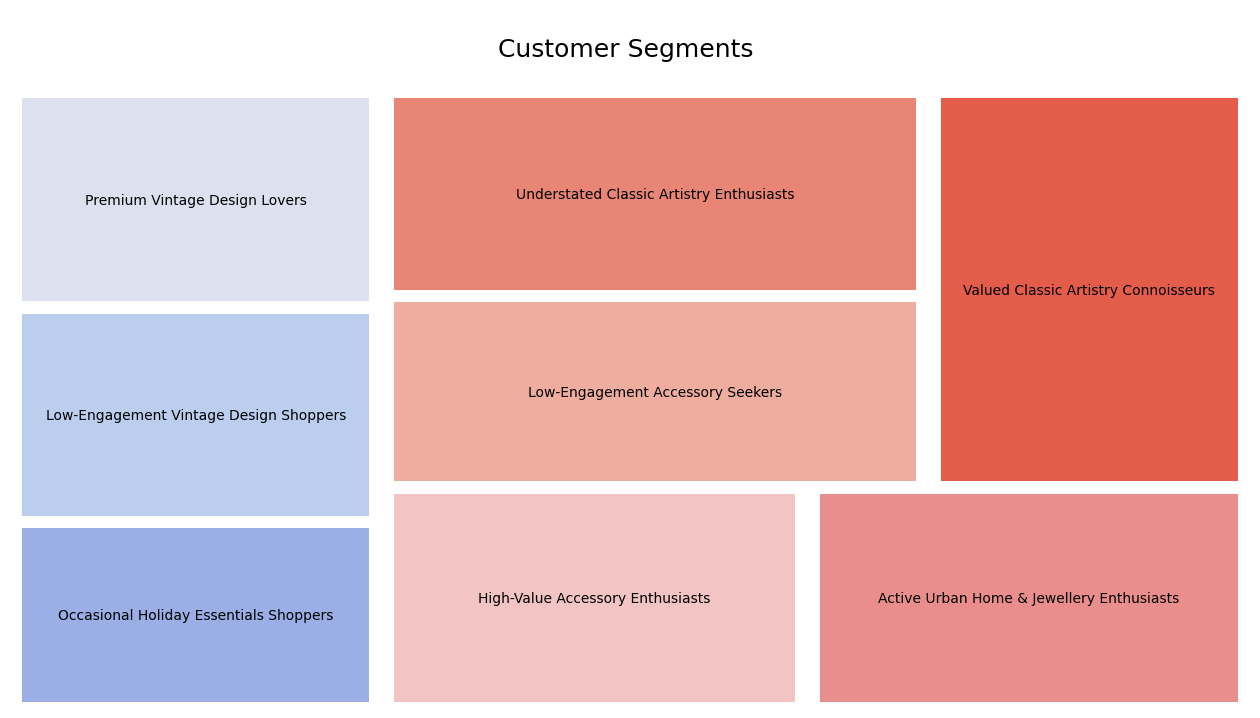

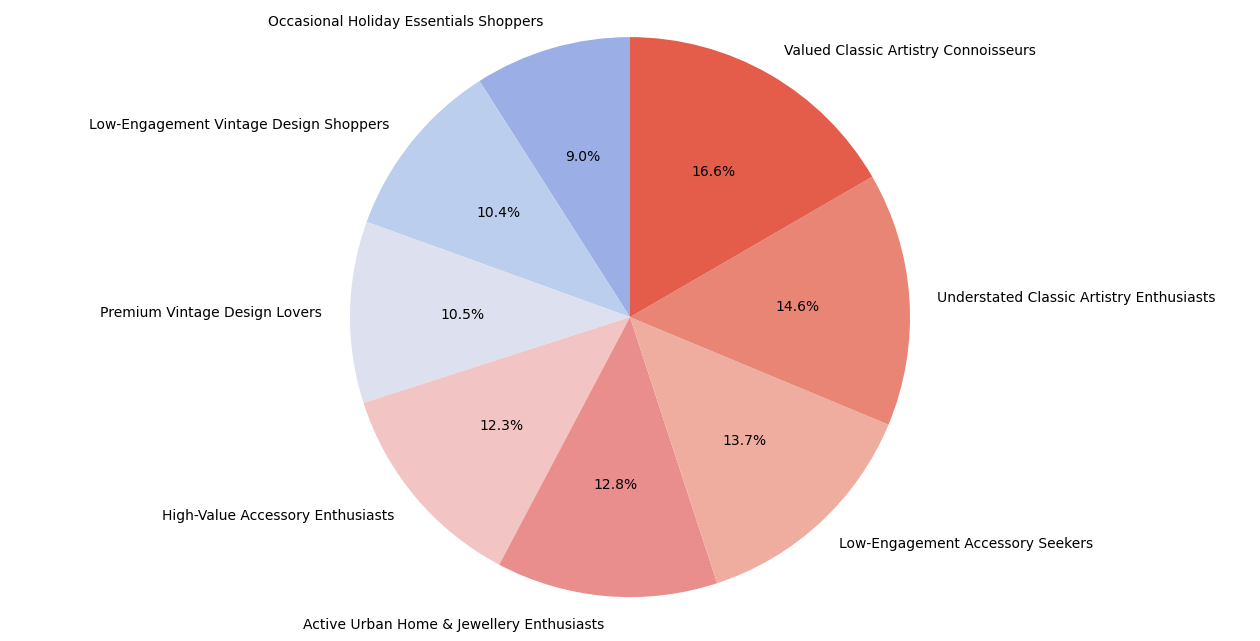

In [46]:
colors = [
    "#9CAEE6",  
    "#BCCEED",  
    "#DDE1EF",  
    "#F3C4C4",  
    "#EA8D8D",  
    "#EFADA0",  
    "#E98575",  
    "#E45C4A"   
]

segment_visualizations(
    summary,
    16,
    8,
    'Number of Customers',
    'Customer Segment',
    colors,
    'Customer Segments',
    sort_by='Number of Customers',
    ascending=True,
    plot_types = ['treemap','pie']
)

#### Cluster's Metrics

<Figure size 1400x800 with 0 Axes>

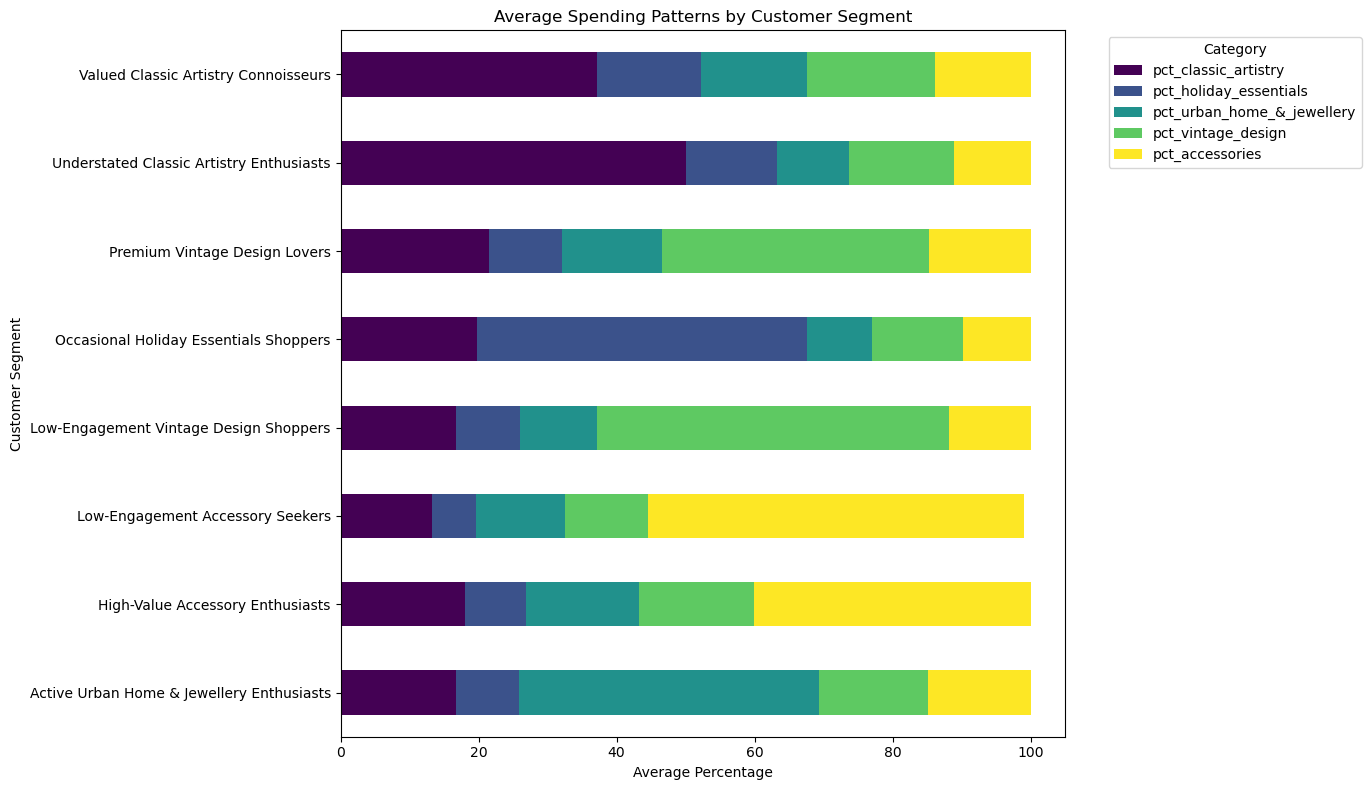

<Figure size 1400x800 with 0 Axes>

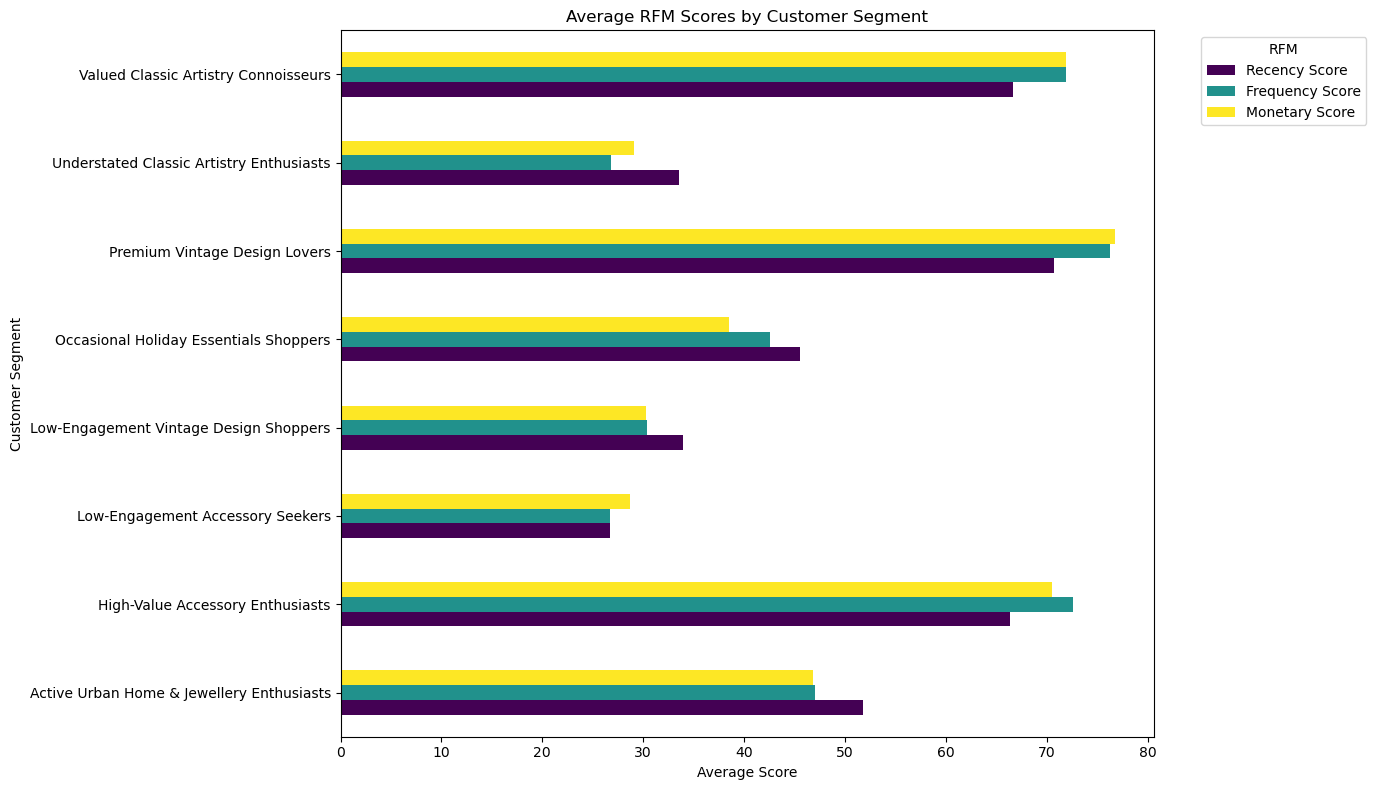

In [47]:
# Average spending patterns - stacked
plt.figure(figsize=(14, 8))  
ax = summary[['pct_classic_artistry',
              'pct_holiday_essentials',
              'pct_urban_home_&_jewellery',
              'pct_vintage_design',
              'pct_accessories']].plot(kind='barh',
                                       stacked=True,
                                       colormap='viridis',
                                       figsize=(14, 8),
                                       grid=False)
ax.set_title('Average Spending Patterns by Customer Segment')
ax.set_ylabel('Customer Segment')
ax.set_xlabel('Average Percentage')
ax.set_yticks(range(len(summary.index)))
ax.set_yticklabels(summary['Customer Segment'])  
ax.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Average RFM scores
plt.figure(figsize=(14, 8))  
ax = summary[['Recency Score',
              'Frequency Score',
              'Monetary Score']].plot(kind='barh',
                                      colormap='viridis',
                                      figsize=(14, 8),
                                      grid=False)
ax.set_title('Average RFM Scores by Customer Segment')
ax.set_ylabel('Customer Segment')
ax.set_xlabel('Average Score')
ax.set_yticks(range(len(summary.index)))
ax.set_yticklabels(summary['Customer Segment']) 
ax.legend(title='RFM', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()